<a href="https://colab.research.google.com/github/Sridipta-Roy/Protein-Function-Prediction/blob/main/02_Embedding_Gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive

# --- Mount drive and basic config ---
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/protein-multimodal')

Mounted at /content/drive


In [ ]:
PROJECT_ROOT = "/content/drive/MyDrive/protein-multimodal"
DATA_DIR = f"{PROJECT_ROOT}/data"
PROCESSED_DIR = f"{DATA_DIR}/processed"
EMBEDDINGS_DIR = f"{DATA_DIR}/embeddings"
MODELS_DIR = f"{PROJECT_ROOT}/models"
RESIDUE_DIR = f"{EMBEDDINGS_DIR}/residue_level"

os.makedirs(EMBEDDINGS_DIR, exist_ok=True)
os.makedirs(RESIDUE_DIR, exist_ok=True)
os.makedirs(f"{MODELS_DIR}/esm2", exist_ok=True)

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Device: {device}")
if device.type == "cuda":
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  WARNING: GPU not available! Enable GPU in Runtime > Change runtime type")


🖥️  Device: cuda
   GPU: NVIDIA A100-SXM4-80GB
   Memory: 85.17 GB


In [ ]:
!pip install -q fair-esm umap-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.5 MB/s eta 0:00:00


In [ ]:
import esm
import json
import numpy as np
from tqdm.notebook import tqdm
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap

### **Load ESM-2 Model**

In [ ]:
model_name = "esm2_t33_650M_UR50D"
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model = model.to(device)
model.eval()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [ ]:
batch_converter = alphabet.get_batch_converter()

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [ ]:
print(f"Total parameters: {params}")
print(f"Model loaded: {model_name}")

Total parameters: 651043254
Model loaded: esm2_t33_650M_UR50D


* Parameters: ~650M"
* Embedding dimension: 1280
* Max sequence length: 1024

In [ ]:
alphabet_path = f"{MODELS_DIR}/esm2/alphabet.pkl"
with open(alphabet_path, "wb") as f:
    pickle.dump(alphabet, f)
print(f"Saved alphabet to {alphabet_path}")

Saved alphabet to /content/drive/MyDrive/protein-multimodal/models/esm2/alphabet.pkl


### **Embedding Generator**

In [ ]:
class ESM2EmbeddingGenerator:
    """
    Generates protein embeddings using ESM-2.
    - Global embeddings (mean/cls/both)
    - Optional per-residue embeddings saved per protein
    """

    def __init__(self, model, alphabet, device="cuda", batch_size=8):
        self.model = model
        self.alphabet = alphabet
        self.batch_converter = alphabet.get_batch_converter()
        self.device = device
        self.batch_size = batch_size

    def generate_embeddings(
        self,
        proteins,
        pool_strategy: str = "mean",
        save_residue: bool = True,
        residue_dir: str = None,
    ):
        """
        Generate embeddings for a list of proteins

        Args:
            proteins: List[dict] with keys: 'accession', 'sequence', 'length', 'function', 'protein_name' (optional)
            pool_strategy: 'mean', 'cls', or 'both'
            save_residue: if True, saves per-residue embeddings (L, 1280) to residue_dir/<accession>.pt
            residue_dir: directory to store per-residue embeddings

        Returns:
            embeddings: Tensor of shape [N, D] (D = 1280 or 2560)
            metadata: List[dict] with protein info
        """
        if save_residue and residue_dir is None:
            raise ValueError("residue_dir must be provided when save_residue=True")

        embeddings = []
        metadata = []

        for i in tqdm(range(0, len(proteins), self.batch_size), desc="Generating embeddings"):
            batch_proteins = proteins[i : i + self.batch_size]
            batch_data = [(p["accession"], p["sequence"]) for p in batch_proteins]

            try:
                batch_embeddings = self._process_batch(
                    batch_data=batch_data,
                    pool_strategy=pool_strategy,
                    save_residue=save_residue,
                    residue_dir=residue_dir,
                )

                for j, protein in enumerate(batch_proteins):
                    embeddings.append(batch_embeddings[j].cpu())
                    metadata.append(
                        {
                            "accession": protein["accession"],
                            "protein_name": protein.get("protein_name", ""),
                            "length": protein["length"],
                            "sequence": protein["sequence"],
                            "function": protein["function"],
                            "go_terms": protein.get("go_terms", []),
                            "ec_numbers": protein.get("ec_numbers", []),
                        }
                    )

            except RuntimeError as e:
                print(f"\n⚠️  Skipping batch starting at index {i} due to error: {e}")
                continue

        # Stack and convert to float16 (saves disk space)
        embeddings_tensor = torch.stack(embeddings).half()
        return embeddings_tensor, metadata

    def _process_batch(
        self,
        batch_data,
        pool_strategy: str = "mean",
        save_residue: bool = True,
        residue_dir: str = None,
    ):
        """
        Process a single batch of sequences.

        - Computes global embeddings using requested pooling strategy.
        - Optionally saves per-residue embeddings to disk.
        """
        batch_labels, batch_strs, batch_tokens = self.batch_converter(batch_data)
        batch_tokens = batch_tokens.to(self.device)

        with torch.no_grad():
            results = self.model(batch_tokens, repr_layers=[33], return_contacts=False)

        token_representations = results["representations"][33]

        batch_embeddings = []
        for i, (label, seq) in enumerate(zip(batch_labels, batch_strs)):
            seq_len = len(seq)

            # Per-residue representation (L, 1280), excluding special tokens
            residue_repr = token_representations[i, 1 : seq_len + 1]

            # Global pooling
            if pool_strategy == "mean":
                seq_repr = residue_repr.mean(dim=0)
            elif pool_strategy == "cls":
                seq_repr = token_representations[i, 0]
            elif pool_strategy == "both":
                mean_repr = residue_repr.mean(dim=0)
                cls_repr = token_representations[i, 0]
                seq_repr = torch.cat([mean_repr, cls_repr], dim=0)
            else:
                raise ValueError(f"Unknown pool_strategy: {pool_strategy}")

            batch_embeddings.append(seq_repr)

            # Save per-residue embeddings (as fp16)
            if save_residue and residue_dir is not None:
                accession = label  # we passed accession as label in batch_data
                safe_accession = accession.replace("/", "_")
                out_path = os.path.join(residue_dir, f"{safe_accession}.pt")
                torch.save(residue_repr.half().cpu(), out_path)

        return torch.stack(batch_embeddings)

### **Load processed datasets**

In [ ]:
with open(f"{PROCESSED_DIR}/train.json", "r") as f:
    train_data = json.load(f)

with open(f"{PROCESSED_DIR}/val.json", "r") as f:
    val_data = json.load(f)

with open(f"{PROCESSED_DIR}/test.json", "r") as f:
    test_data = json.load(f)

print(f"**Loaded datasets:")
print(f"  - Train: {len(train_data)} proteins")
print(f"  - Val:   {len(val_data)} proteins")
print(f"  - Test:  {len(test_data)} proteins")

**Loaded datasets:
  - Train: 7989 proteins
  - Val:   999 proteins
  - Test:  999 proteins


### **Save embeddings + metadata**

In [ ]:
def save_embeddings(embeddings, metadata, prefix, save_dir):
    """Save embeddings (tensor) and metadata (JSON)."""
    emb_path = f"{save_dir}/{prefix}_embeddings.pt"
    torch.save(embeddings, emb_path)

    meta_path = f"{save_dir}/{prefix}_metadata.json"
    with open(meta_path, "w") as f:
        json.dump(metadata, f, indent=2)

    emb_size = os.path.getsize(emb_path) / (1024 * 1024)
    meta_size = os.path.getsize(meta_path) / (1024 * 1024)

    print(f" {prefix}:")
    print(f"    - Embeddings: {emb_path} ({emb_size:.2f} MB)")
    print(f"    - Metadata:   {meta_path} ({meta_size:.2f} MB)")

### **Generate embeddings for all splits**

In [ ]:
generator = ESM2EmbeddingGenerator(
    model=model,
    alphabet=alphabet,
    device=device,
    batch_size=8,
)

POOL_STRATEGY = "mean"  # 'mean', 'cls', or 'both'


In [ ]:
train_embeddings, train_metadata = generator.generate_embeddings(
    train_data,
    pool_strategy=POOL_STRATEGY,
    save_residue=True,
    residue_dir=RESIDUE_DIR,
)
print(f"Train embeddings shape: {train_embeddings.shape}")
save_embeddings(train_embeddings, train_metadata, "train", EMBEDDINGS_DIR)

Generating embeddings:   0%|          | 0/999 [00:00<?, ?it/s]


⚠️  Skipping batch starting at index 144 due to error: CUDA out of memory. Tried to allocate 46.15 GiB. GPU 0 has a total capacity of 79.32 GiB of which 23.90 GiB is free. Process 12715 has 55.41 GiB memory in use. Of the allocated memory 50.36 GiB is allocated by PyTorch, and 4.55 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

⚠️  Skipping batch starting at index 976 due to error: CUDA out of memory. Tried to allocate 41.92 GiB. GPU 0 has a total capacity of 79.32 GiB of which 23.91 GiB is free. Process 12715 has 55.39 GiB memory in use. Of the allocated memory 46.04 GiB is allocated by PyTorch, and 8.87 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:T

In [ ]:
val_embeddings, val_metadata = generator.generate_embeddings(
    val_data,
    pool_strategy=POOL_STRATEGY,
    save_residue=True,
    residue_dir=RESIDUE_DIR,
)
print(f"Val embeddings shape: {val_embeddings.shape}")
save_embeddings(val_embeddings, val_metadata, "val", EMBEDDINGS_DIR)

Generating embeddings:   0%|          | 0/125 [00:00<?, ?it/s]


⚠️  Skipping batch starting at index 248 due to error: CUDA out of memory. Tried to allocate 32.55 GiB. GPU 0 has a total capacity of 79.32 GiB of which 28.50 GiB is free. Process 12715 has 50.81 GiB memory in use. Of the allocated memory 36.47 GiB is allocated by PyTorch, and 13.85 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Val embeddings shape: torch.Size([991, 1280])
 val:
    - Embeddings: /content/drive/MyDrive/protein-multimodal/data/embeddings/val_embeddings.pt (2.42 MB)
    - Metadata:   /content/drive/MyDrive/protein-multimodal/data/embeddings/val_metadata.json (3.06 MB)


In [ ]:
test_embeddings, test_metadata = generator.generate_embeddings(
    test_data,
    pool_strategy=POOL_STRATEGY,
    save_residue=True,
    residue_dir=RESIDUE_DIR,
)
print(f"Test embeddings shape: {test_embeddings.shape}")
save_embeddings(test_embeddings, test_metadata, "test", EMBEDDINGS_DIR)

Generating embeddings:   0%|          | 0/125 [00:00<?, ?it/s]

Test embeddings shape: torch.Size([999, 1280])
 test:
    - Embeddings: /content/drive/MyDrive/protein-multimodal/data/embeddings/test_embeddings.pt (2.44 MB)
    - Metadata:   /content/drive/MyDrive/protein-multimodal/data/embeddings/test_metadata.json (2.98 MB)


### **Verify embeddings**

In [ ]:
loaded_train = torch.load(f"{EMBEDDINGS_DIR}/train_embeddings.pt", map_location="cpu")
print(f"\nSuccessfully loaded train embeddings")
print(f"  Shape: {loaded_train.shape}")
print(f"  Dtype: {loaded_train.dtype}")
print(f"  Device: {loaded_train.device}")


Successfully loaded train embeddings
  Shape: torch.Size([7949, 1280])
  Dtype: torch.float16
  Device: cpu


In [ ]:
with open(f"{EMBEDDINGS_DIR}/train_metadata.json", "r") as f:
    loaded_meta = json.load(f)
print(f"\n✓ Successfully loaded train metadata")
print(f"  Entries: {len(loaded_meta)}")
print(f"  Sample keys: {list(loaded_meta[0].keys())}")

assert loaded_train.shape[0] == len(loaded_meta), "Mismatch between embeddings and metadata!"
print(f"\n✓ Embeddings and metadata are aligned")


✓ Successfully loaded train metadata
  Entries: 7949
  Sample keys: ['accession', 'protein_name', 'length', 'sequence', 'function', 'go_terms', 'ec_numbers']

✓ Embeddings and metadata are aligned


### **Embedding statistics + visualization**

In [ ]:
print(f"\nTrain embeddings statistics:")
print(f"  - Mean: {train_embeddings.float().mean().item():.4f}")
print(f"  - Std:  {train_embeddings.float().std().item():.4f}")
print(f"  - Min:  {train_embeddings.float().min().item():.4f}")
print(f"  - Max:  {train_embeddings.float().max().item():.4f}")


Train embeddings statistics:
  - Mean: -0.0009
  - Std:  0.2019
  - Min:  -8.6172
  - Max:  1.7480



📈 Visualizing embedding space...
  Computing UMAP projection...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  ✓ Saved visualization to /content/drive/MyDrive/protein-multimodal/data/embeddings/embedding_visualization.png


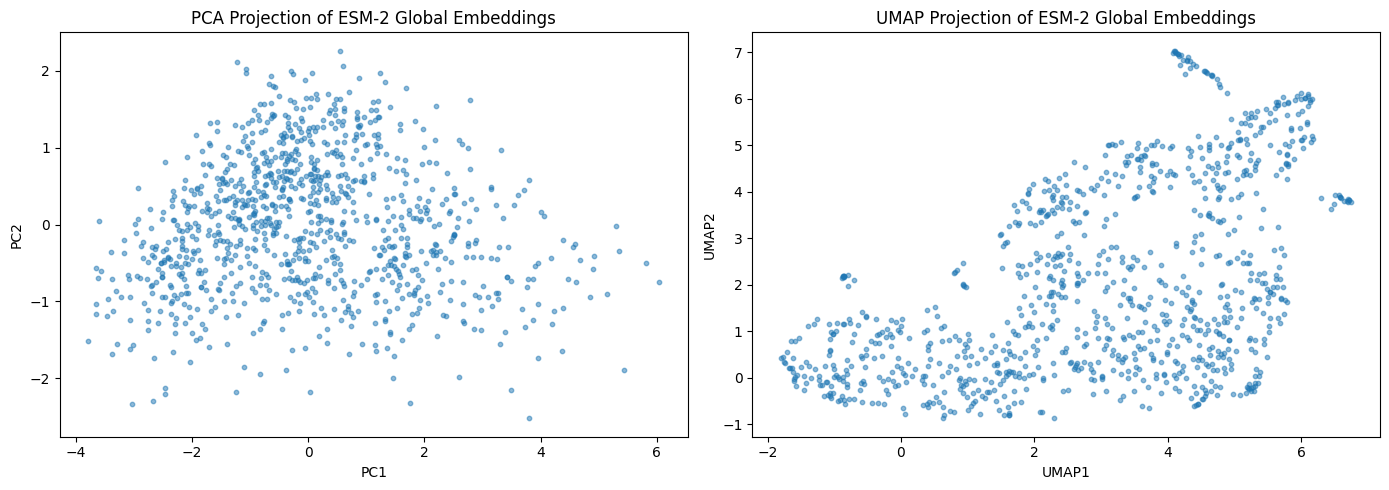

In [ ]:
if torch.isnan(train_embeddings).any():
    print("  ⚠️  WARNING: NaN values detected in train embeddings!")
if torch.isinf(train_embeddings).any():
    print("  ⚠️  WARNING: Inf values detected in train embeddings!")

try:
    print("\n📈 Visualizing embedding space...")
    sample_size = min(1000, len(train_embeddings))
    sample_embeddings = train_embeddings[:sample_size].float().numpy()

    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(sample_embeddings)

    print("  Computing UMAP projection...")
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    umap_embeddings = umap_reducer.fit_transform(sample_embeddings)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], alpha=0.5, s=10)
    axes[0].set_title("PCA Projection of ESM-2 Global Embeddings")
    axes[0].set_xlabel("PC1")
    axes[0].set_ylabel("PC2")

    axes[1].scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], alpha=0.5, s=10)
    axes[1].set_title("UMAP Projection of ESM-2 Global Embeddings")
    axes[1].set_xlabel("UMAP1")
    axes[1].set_ylabel("UMAP2")

    plt.tight_layout()
    viz_path = f"{EMBEDDINGS_DIR}/embedding_visualization.png"
    plt.savefig(viz_path, dpi=150)
    print(f"  ✓ Saved visualization to {viz_path}")
    plt.show()

except Exception as e:
    print(f"  ⚠️  Visualization skipped: {e}")

In [ ]:
summary = {
    "model": model_name,
    "embedding_dim": train_embeddings.shape[1],
    "pooling_strategy": POOL_STRATEGY,
    "train_size": len(train_embeddings),
    "val_size": len(val_embeddings),
    "test_size": len(test_embeddings),
    "device_used": str(device),
    "statistics": {
        "train_mean": float(train_embeddings.float().mean()),
        "train_std": float(train_embeddings.float().std()),
        "val_mean": float(val_embeddings.float().mean()),
        "val_std": float(val_embeddings.float().std()),
        "test_mean": float(test_embeddings.float().mean()),
        "test_std": float(test_embeddings.float().std()),
    },
}

with open(f"{EMBEDDINGS_DIR}/embedding_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print(f"\n✓ Saved summary to {EMBEDDINGS_DIR}/embedding_summary.json")

print("\n📁 Generated files in embeddings dir:")
for file in sorted(os.listdir(EMBEDDINGS_DIR)):
    filepath = os.path.join(EMBEDDINGS_DIR, file)
    size = os.path.getsize(filepath) / (1024 * 1024)
    print(f"  - {file}: {size:.2f} MB")

print("\n📁 Residue-level embedding files (first 10):")
res_files = sorted(os.listdir(RESIDUE_DIR))[:10]
for file in res_files:
    filepath = os.path.join(RESIDUE_DIR, file)
    size = os.path.getsize(filepath) / (1024 * 1024)
    print(f"  - {file}: {size:.2f} MB")


✓ Saved summary to /content/drive/MyDrive/protein-multimodal/data/embeddings/embedding_summary.json

📁 Generated files in embeddings dir:
  - embedding_summary.json: 0.00 MB
  - embedding_visualization.png: 0.12 MB
  - residue_level: 0.00 MB
  - test_embeddings.pt: 2.44 MB
  - test_metadata.json: 2.73 MB
  - train_embeddings.pt: 19.53 MB
  - train_metadata.json: 22.03 MB
  - val_embeddings.pt: 2.44 MB
  - val_metadata.json: 2.82 MB

📁 Residue-level embedding files (first 10):
  - A0A1B0GTW7.pt: 1.93 MB
  - A0PK11.pt: 0.57 MB
  - A1A4S6.pt: 1.92 MB
  - A1A519.pt: 0.81 MB
  - A1L190.pt: 0.22 MB
  - A1L3X0.pt: 0.69 MB
  - A1X283.pt: 2.23 MB
  - A2A2Y4.pt: 1.46 MB
  - A2RUB6.pt: 2.32 MB
  - A2RUC4.pt: 0.77 MB
